In [18]:

#general
import io

# data
import numpy as np
import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [19]:
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

In [20]:
# Updates dataframe to use specific columns.
training_df = chicago_taxi_dataset[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
0,2.57,2341,31.99,Flash Cab,Mobile,6.3
1,1.18,1074,9.75,Flash Cab,Credit Card,27.9
2,1.29,1173,10.25,Sun Taxi,Cash,0.0
3,3.70,3360,23.75,Choice Taxi Association,Cash,0.0
4,1.15,1044,10.00,Flash Cab,Cash,0.0
...,...,...,...,...,...,...
195,1.13,821,9.00,Blue Ribbon Taxi Association,Mobile,22.9
196,0.57,414,6.00,Flash Cab,Cash,0.0
197,1.22,886,9.00,City Service,Cash,0.0
198,1.68,1219,9.00,Sun Taxi,Mobile,23.0


In [21]:
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694,31694,31694.000000
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.289463,1319.796397,23.905210,NaN,NaN,12.965785
std,7.265672,928.932873,16.970022,NaN,NaN,15.517765
min,0.500000,60.000000,3.250000,NaN,NaN,0.000000
25%,1.720000,548.000000,9.000000,NaN,NaN,0.000000
50%,5.920000,1081.000000,18.750000,NaN,NaN,12.200000
75%,14.500000,1888.000000,38.750000,NaN,NaN,20.800000


In [22]:
#What is the max fare?
max_fare = training_df['FARE'].max()
print('Max fare: {0}'.format(max_fare))

mean_distance = training_df['TRIP_MILES'].mean()
print('Mean distance: {0}'.format(mean_distance))

num_unique_companies = training_df['COMPANY'].nunique()
print('Number of unique companies: {0}'.format(num_unique_companies))

most_freq_payment_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print('Most frequent payment type: {0}'.format(most_freq_payment_type))

missing_values = training_df.isnull().sum().sum()
print('Number of missing values: {0}'.format(missing_values))


Max fare: 159.25
Mean distance: 8.289462674323214
Number of unique companies: 31
Most frequent payment type: Credit Card
Number of missing values: 0


In [23]:
training_df.corr(numeric_only = True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


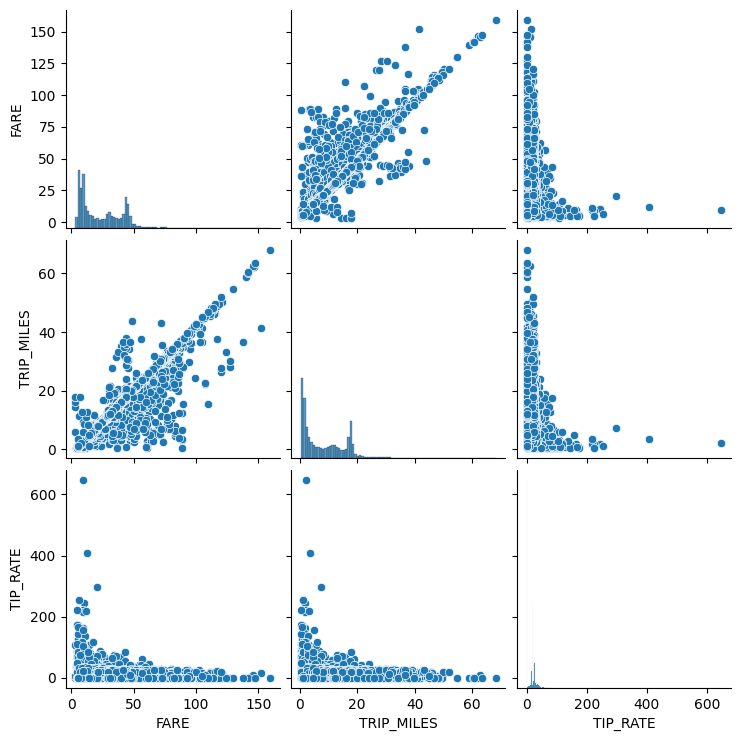

In [24]:
sns.pairplot(training_df, x_vars=['FARE', 'TRIP_MILES', 'TIP_RATE'], y_vars=['FARE', 'TRIP_MILES', 'TIP_RATE'])

In [25]:
def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [26]:
def build_model(my_learning_rate, num_features):
    """Crating and compiling a simple linear regression model"""
    inputs = keras.Input(shape=(num_features,))
    outputs = keras.layers.Dense(units=1)(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    #compile the model
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])
    return model

def train_model(model, df, feature_names, label_name, epochs, batch_size):
    """Training the model"""
    history = model.fit(x=feature_names, y=label_name, batch_size=batch_size, epochs=epochs)
    
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]
    
    return trained_weight, trained_bias, epochs, rmse

def run_experiment(df,feature_names,label_names, learning_rate, epochs, batch_size):
    print('INFO: Starting training experiment with features:{} and label:{}\n'.format(feature_names, label_names))
    
    num_features = len(feature_names)
    features = df.loc[:,feature_names].values
    print(features)
    label = df[label_names].values
    print(label)
    model = build_model(learning_rate, num_features)
    model_output = train_model(model, df, features, label, epochs, batch_size)
    
    print('\nSUCCESS: Training experiment completed.\n')
    print('{}'.format(model_info(feature_names, label_names, model_output)))
    make_plots(df, feature_names, label_names, model_output)

    return model

print("SUCCESS: defining linear regression functions complete.")
    

SUCCESS: defining linear regression functions complete.


In [27]:
#hyperparameters
learning_rate = 0.001
epochs = 20
batch_size = 50

features = ['TRIP_MILES']
label = 'FARE'

model_1 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: Starting training experiment with features:['TRIP_MILES'] and label:FARE

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 542.1606 - root_mean_squared_error: 23.2645
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 267.4904 - root_mean_squared_error: 16.3201
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 88.8971 - root_mean_squared_error: 9.3910
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 21.7119 - root_mean_squared_error: 4.6543
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 15.2627 - root_mean_squared_error: 3.9018
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 15.4563 - root_mean_squared_error: 3.9284
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 15.6365 - root_mean_squared_error: 3.9490
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 13.6950 - root_mean_squared_error: 3.6905
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 13.2796 - root_mean_sq

In [28]:
# learning_rate = 1.00
# epochs = 20
# batch_size = 50

# features = ['TRIP_MILES']
# label = 'FARE'

# model_2 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

In [29]:
# learning_rate = 0.0001
# epochs = 200
# batch_size = 50

# features = ['TRIP_MILES']
# label = 'FARE'

# model_3 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

In [30]:
# learning_rate = 0.001
# epochs = 20
# batch_size = 500

# features = ['TRIP_MILES']
# label = 'FARE'

# model_4 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

In [34]:
learning_rate = 0.001
epochs = 20
batch_size = 50

training_df.loc[:, 'TRIP_MINUTES'] = training_df['TRIP_SECONDS'] / 60

features = ['TRIP_MILES', 'TRIP_MINUTES']
label = 'FARE'

model_5 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: Starting training experiment with features:['TRIP_MILES', 'TRIP_MINUTES'] and label:FARE

Epoch 1/20


/tmp/ipykernel_433559/346238295.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - loss: 121.1893 - root_mean_squared_error: 11.0035
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 82.6405 - root_mean_squared_error: 9.0856
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 52.9742 - root_mean_squared_error: 7.2682
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 30.2783 - root_mean_squared_error: 5.5005
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - loss: 20.6929 - root_mean_squared_error: 4.5264
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - loss: 15.6264 - root_mean_squared_error: 3.9319
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 12.9677 - root_mean_squared_error: 3.5967
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 11.8284 - root_mean_squared_error: 3.4266
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 12.0210 - root_mean_squared_error: 3.4533
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 11.8665 - 

In [35]:
def format_currency(x):
  return "${:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)
  predicted_values = model.predict_on_batch(x=batch.loc[:, features].values)

  data = {"PREDICTED_FARE": [], "OBSERVED_FARE": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data["PREDICTED_FARE"].append(format_currency(predicted))
    data["OBSERVED_FARE"].append(format_currency(observed))
    data["L1_LOSS"].append(format_currency(abs(observed - predicted)))
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)
  print(output)
  return

In [36]:
output = predict_fare(model_5, training_df, features, label)
show_predictions(output)

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
   PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MILES TRIP_MINUTES
0          $16.99        $16.50   $0.49        5.31        16.83
1          $34.25        $34.75   $0.50       13.84        16.83
2          $25.32        $25.50   $0.18        9.11        21.28
3           $6.85         $6.75   $0.10        1.00         7.00
4           $8.03         $8.25   $0.22        1.30        11.00
5           $7.51         $7.25   $0.26        1.26         7.93
6          $50.55        $51.50   $0.95       21.26        25.75
7          $39.54        $40.00   $0.46       15.90        24.63
8          $44.16        $44.25   $0.09       17.80        30.00
9          $11.38        $12.25   $0.87        2.32        19.95
10         $46.49        $45.50   $0.99   